In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
my_output = None

In [8]:
import torch
from diffusers.schedulers.scheduling_dpmsolver_multistep import DPMSolverMultistepScheduler

class BackPropRepaintScheduler(DPMSolverMultistepScheduler):

    def __init__(
        self,
        **kwargs,
    ):
        super().__init__(**kwargs)

    def convert_model_output(
        self,
        model_output: torch.FloatTensor,
        *args,
        sample: torch.FloatTensor = None,
        **kwargs,
    ) -> torch.FloatTensor:
        
        output = super().convert_model_output(model_output, *args, sample=sample, **kwargs)

        # DPM-Solver++ needs to solve an integral of the data prediction model.
        if self.config.algorithm_type in ["dpmsolver++", "sde-dpmsolver++"]:
            x0_pred = output
            x0_pred = self._backprob_inpaint(x0_pred)

            return x0_pred

        # DPM-Solver needs to solve an integral of the noise prediction model.
        elif self.config.algorithm_type in ["dpmsolver", "sde-dpmsolver"]:
            epsilon = output

            sigma = self.sigmas[self.step_index]
            alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
            x0_pred = (sample - sigma_t * epsilon) / alpha_t
            x0_pred = self._backprob_inpaint(x0_pred)
            epsilon = (sample - alpha_t * x0_pred) / sigma_t

            return epsilon

    def _backprob_inpaint(self, x0_pred, lr=1e-2, num_iter=10):
        if hasattr(self, 'vae') and hasattr(self, 'mask'):
            for i in range(num_iter):
                x0_pred.requires_grad = True

                with torch.enable_grad():
                    scaled_latent = 1 / self.vae.config.scaling_factor * x0_pred
                    image = self.vae.decode(scaled_latent, return_dict=False)[0]
                
                    loss = (image - self.mask)[self.mask != 0].abs().sum()
                    grads = torch.autograd.grad(outputs=loss, inputs=x0_pred)[0]
                x0_pred = x0_pred - lr * grads
        
        return x0_pred
    
    def add_vae(self, vae):
        vae.requires_grad = True
        self.vae = vae
        
    def add_mask(self, mask):
        mask.requires_grad = True
        self.mask = mask

## Vanilla Generation

In [9]:
import torch
from diffusers import StableDiffusionPipeline 
# DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

config = {
    "beta_start": 0.00085,
    "trained_betas": None,
    "prediction_type": "v_prediction",
    "beta_schedule": "scaled_linear",
    "steps_offset": 1,
    "beta_end": 0.012,
    "num_train_timesteps": 1000,
    "thresholding": True,
    # "backprob_repaint": True
}
pipe.scheduler = BackPropRepaintScheduler(**config)
pipe.scheduler.add_vae(pipe.vae)
# pipe.scheduler.add_mask(None)

pipe = pipe.to("cuda")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

1111  "tensor[1000] 3.9Kb x∈[-2.682, 3.535] μ=-0.483 σ=1.195"


  0%|          | 0/50 [00:00<?, ?it/s]

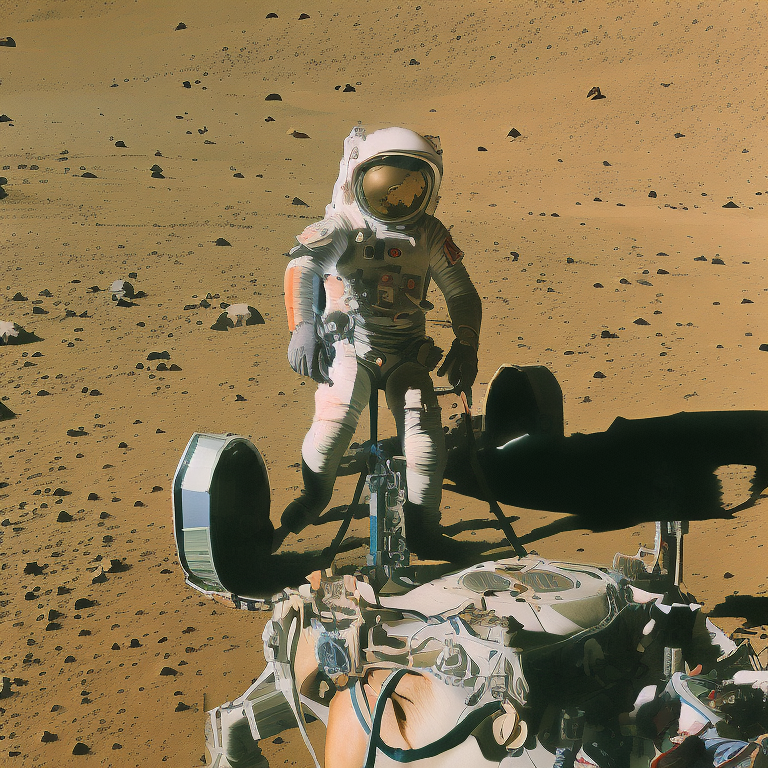

In [10]:
prompt = "extremly high quality photo of an astronaut riding a horse on mars"
output = pipe(prompt)
image = output.images[0]
image

1111  "tensor[1, 3, 768, 768] n=1769472 (6.8Mb) x∈[0., 1.000] μ=0.447 σ=0.167 cuda:0"


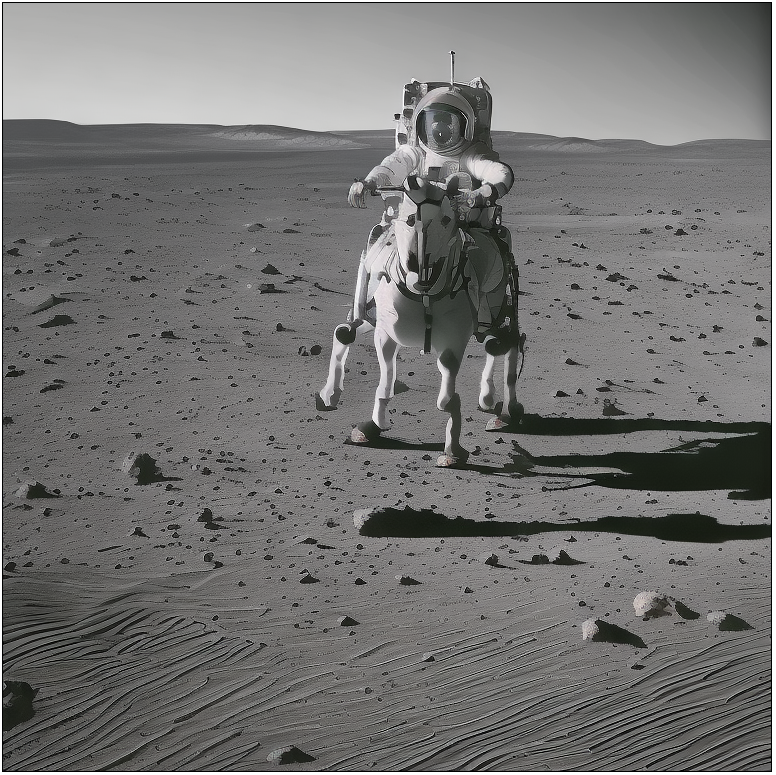

In [ ]:
with torch.no_grad():
    latents = 1 / pipe.vae.config.scaling_factor * my_output.detach()
    my_img = pipe.vae.decode(latents, return_dict=False)[0]
    my_img_rescaled = (my_img / 2 + 0.5).clamp(0, 1)
    
import jhutil; jhutil.jhprint(1111, my_img_rescaled)
my_img_rescaled.rgb

## Masked Generation

In [ ]:
import torch

def generate_random_coordinates(n, h, w):
    y_coords = torch.randint(0, h, (n,))
    x_coords = torch.randint(0, w, (n,))
    coords = torch.stack((x_coords, y_coords), dim=1)

    return coords

def mask_image_except_coordinates(image, coordinates):
    mask = torch.zeros_like(image)
    mask[:, :, coordinates[:, 1], coordinates[:, 0]] = 1
    masked_image = image * mask

    return masked_image.detach()


coord = generate_random_coordinates(10000, *my_img.shape[2:])
masked_image = mask_image_except_coordinates(my_img, coord)

  0%|          | 0/50 [00:00<?, ?it/s]

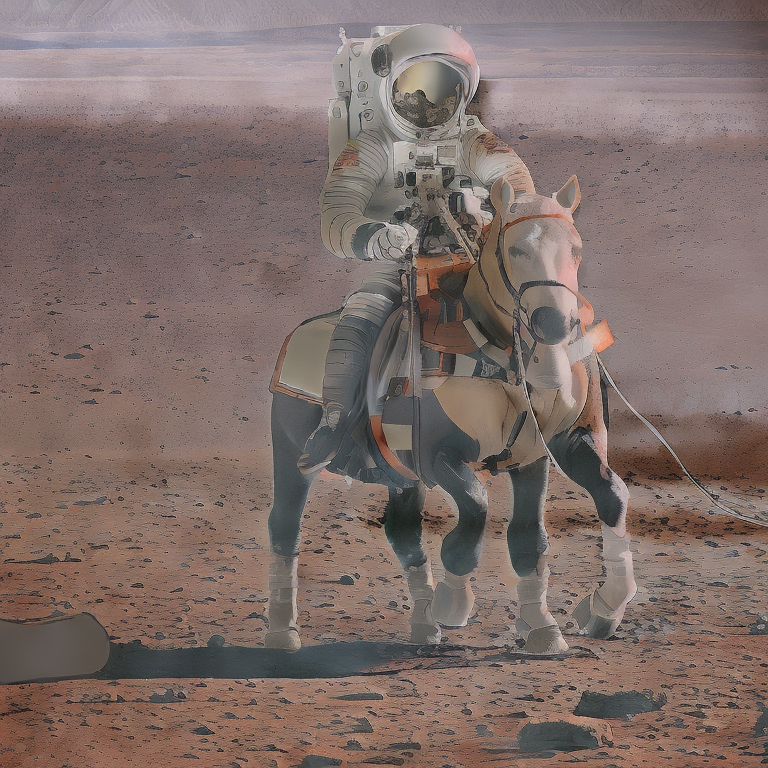

In [ ]:
pipe.scheduler.add_mask(masked_image)
pipe.scheduler.add_vae(pipe.vae)

prompt = "extremly high quality photo of an astronaut riding a horse on mars"
output = pipe(prompt)
image = output.images[0]
image

1111  "tensor[1, 3, 768, 768] n=1769472 (6.8Mb) x∈[0., 0.965] μ=0.451 σ=0.127 cuda:0"


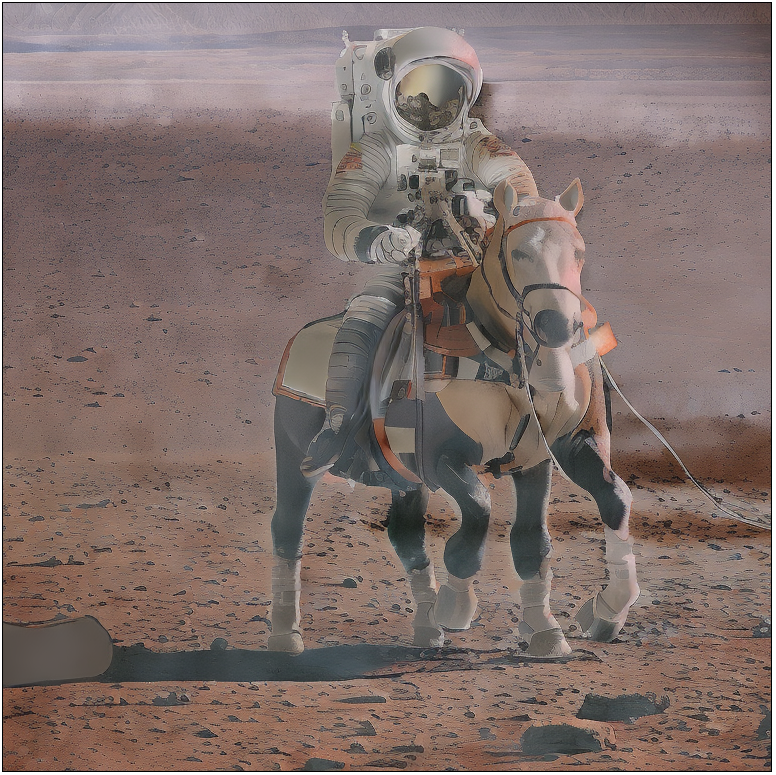

In [ ]:
with torch.no_grad():
    latents = 1 / pipe.vae.config.scaling_factor * my_output.detach()
    my_img = pipe.vae.decode(latents, return_dict=False)[0]
    my_img_rescaled = (my_img / 2 + 0.5).clamp(0, 1)

import jhutil; jhutil.jhprint(1111, my_img_rescaled)
my_img_rescaled.rgb

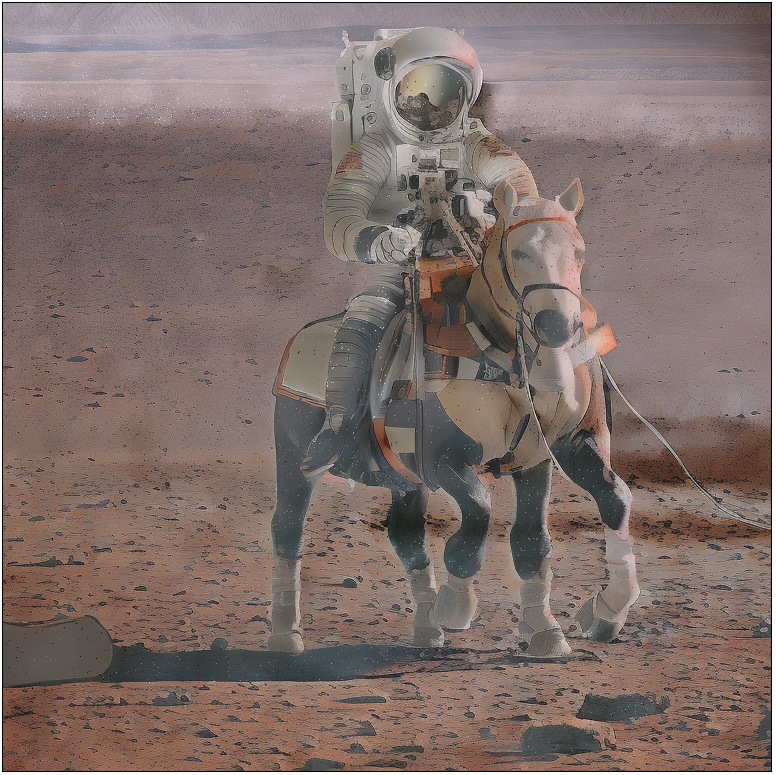

In [ ]:
my_img[masked_image != 0] = masked_image[masked_image != 0]
(my_img / 2 + 0.5).clamp(0, 1).rgb